In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# this will probably be deprecated now we have code to mark galaxies as outside the overlap regions
# going forward, it will be simpler to just select any tile and only galaxies not in the overlap region
# then we just maintain a list of uploaded tiles to skip in future

In [2]:
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 0) #to show full column content (no wrapping and no dots)
from sklearn.neighbors import NearestNeighbors


In [6]:
download_dir = '/home/walml/repos/gz-euclid-datalab/data/pipeline/v2_challenge_launch'
catalog_dir = download_dir + '/catalogs'
tile_dir = download_dir + '/tiles'

In [7]:
# quick check
catalog_locs = glob.glob(catalog_dir + '/*_mer_catalog.csv')
print(f'Found {len(catalog_locs)} catalogs')
master_catalog = pd.concat([pd.read_csv(c) for c in catalog_locs], axis=0)
print(f'Found {len(master_catalog)} sources')


Found 94 catalogs
Found 82630 sources


In [8]:

# TODO apply any galaxy-level random subselection?
# nah, I think tile-level subselection will be enough. It's clearer to do every relevant source in a given tile. Then we have a list of classified tiles.

# master_catalog['jpg_loc_composite'] = master_catalog.apply(
#     lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg', version_suffix='composite', oneway_hash=False), axis=1)
# master_catalog['jpg_loc_vis_only'] = master_catalog.apply(
#     lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg', version_suffix='vis_only', oneway_hash=False), axis=1)
# master_catalog['jpg_loc_vis_lsb'] = master_catalog.apply(
#     lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg', version_suffix='vis_lsb', oneway_hash=False), axis=1)
# master_catalog['fits_loc'] = master_catalog.apply(
#     lambda x: pipeline_utils.get_cutout_loc(cutout_folder.replace('jpg', 'fits'), x, output_format='fits.gz', version_suffix='fits', oneway_hash=False), axis=1)

# master_catalog['vis_tile'] = master_catalog['vis_tile'].apply(lambda x: os.path.join(tile_dir, os.path.basename(x)))
# master_catalog['y_tile'] = master_catalog['y_tile'].apply(lambda x: os.path.join(tile_dir, os.path.basename(x)))
# master_catalog['vis_tile_ready'] = master_catalog['vis_tile'].apply(lambda x: os.path.exists(x))
# master_catalog['y_tile_ready'] = master_catalog['y_tile'].apply(lambda x: os.path.exists(x))
# print(f'Found {master_catalog["vis_tile_ready"].sum()} visual tiles and {master_catalog["y_tile_ready"].sum()} Y tiles')

print(master_catalog[~master_catalog['vis_tile_ready']]['tile_index'].unique())

# master_catalog = master_catalog.query('vis_tile_ready and y_tile_ready')

# also restrict to below 5000px in area, just in case of recognisable galaxies
# print(f'{len(master_catalog)} sources after area filter')
# master_catalog = master_catalog.query('segmentation_area < 25000')
# yes, but do it in the upload script not here. Will be saved with the 'master catalog of subject set x' file by upload script

# master_catalog.to_csv(base_catalog_dir + '/_master_catalog.csv', index=False)  # _ to appear first

Found 0 visual tiles and 0 Y tiles
[102020561 102028213 102030408 102034447 102028781 102012400 102019150
 102034448 102023999 102022990 102032104 102024506 102026603 102035627
 102030405 102013966 102042352 102031525 102025025 102033263 102022002
 102012403 102023993 102015620 102028215 102032096 102025037 102034444
 102017361 102032117 102026083 102022015 102036819 102033849 102021041
 102019633 102031550 102042351 102027667 102016036 102035034 102034406
 102028760 102036817 102016054 102017336 102027661 102012787 102030421
 102028782 102022027 102021057 102016896 102030973 102027675 102016463
 102028217 102022013 102021034 102018234 102021511 102038026 102030997
 102041725 102025020 102030972 102017360 102028753 102028219 102027664
 102029879 102013176 102026099 102015615 102030411 102021061 102020090
 102018254 102026063 102018712 102013571 102032115 102022988 102025555
 102022017 102025576 102032685 102019169 102033246 102023521 102030968
 102026098 102011655 102025018]


In [25]:

# unique_df = master_catalog.groupby('tile_index').agg({'right_ascension': 'mean', 'declination': 'mean'}).reset_index()  # used for first two uploads
tile_df = master_catalog[['tile_index', 'tile_ra', 'tile_dec']].drop_duplicates().reset_index()  # more precise, actual tile centre
# construct a non-overlapping set of tiles, to avoid duplication in the overlap area


nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='euclidean').fit(tile_df[['tile_ra', 'tile_dec']])

distances, indices = nbrs.kneighbors(tile_df[['tile_ra', 'tile_dec']])
tile_df['nearest_distance'] = distances[:, 1]
tile_df['nearest_index'] = indices[:, 1]

In [26]:
tile_df.sort_values('nearest_distance', ascending=False)

,index,tile_index,tile_ra,tile_dec,nearest_distance,nearest_index
23,0,102015620,85.915732,-54.5,3.004802,80
75,0,102021061,96.393738,-48.5,2.988953,51
39,0,102016036,78.174544,-54.0,2.618105,55
58,0,102021034,76.218304,-48.5,2.390425,20
5,0,102012400,79.257356,-58.5,2.340532,15
...,...,...,...,...,...,...
65,0,102030972,75.388941,-39.0,0.512722,74
42,0,102028760,80.220307,-41.0,0.503241,24
24,0,102028215,80.163286,-41.5,0.503241,42
45,0,102017336,73.904251,-52.5,0.500267,52


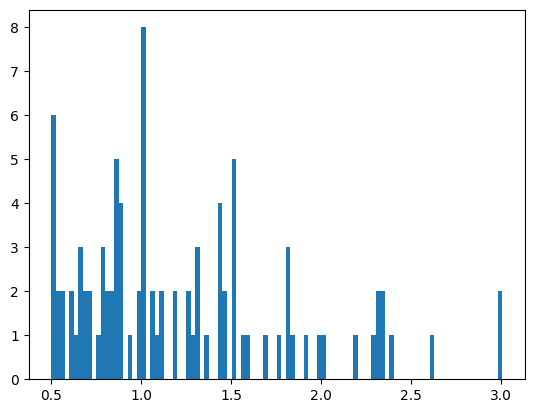

In [27]:
_ = plt.hist(tile_df['nearest_distance'], bins=100)  # 0.5ish is touching, 0.71ish is touching diagonally

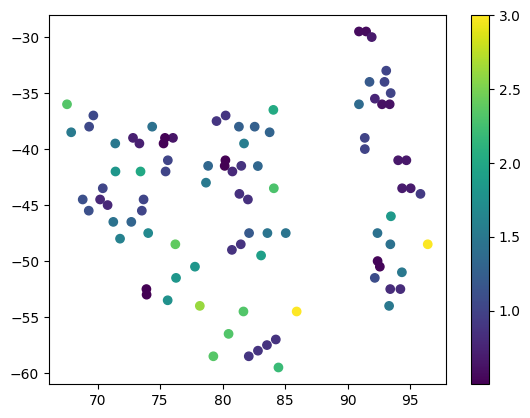

In [28]:
plt.scatter(tile_df['tile_ra'], tile_df['tile_dec'], c=tile_df['nearest_distance'])
plt.colorbar()

50
1.0096922388223104


Text(0.5, 1.0, 'First 50 tiles to upload')

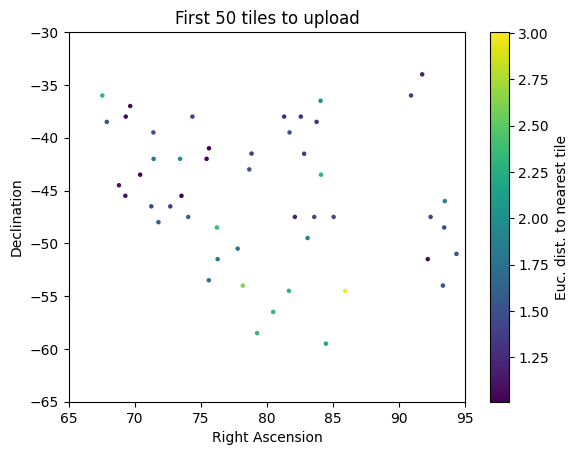

In [30]:
safe_df = tile_df.sort_values('nearest_distance', ascending=False)[:50]

plt.scatter(safe_df['tile_ra'], safe_df['tile_dec'], c=safe_df['nearest_distance'], s=5)
plt.colorbar(label='Euc. dist. to nearest tile')
print(len(safe_df))
plt.ylim([-65, -30])
plt.xlim([65, 95])
print(safe_df['nearest_distance'].min())
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title('First 50 tiles to upload')

In [31]:
safe_df['tile_index'].unique()

array([102015620, 102021061, 102016036, 102021034, 102012400, 102034406,
       102013966, 102015615, 102026083, 102011655, 102033849, 102027664,
       102020090, 102023521, 102018234, 102019150, 102027661, 102016463,
       102022002, 102021511, 102030421, 102031525, 102026603, 102018712,
       102030405, 102016054, 102022015, 102022017, 102022988, 102022027,
       102021057, 102032104, 102034444, 102028213, 102028219, 102022990,
       102031550, 102032115, 102032117, 102022013, 102036817, 102025018,
       102023993, 102018254, 102032096, 102033246, 102026063, 102027667,
       102028753, 102023999])

In [32]:
# array([102015620, 102021061, 102016036, 102021034, 102015615, 102034406,
#        102012400, 102013966, 102026083, 102011655, 102027664, 102033849,
#        102020090, 102023521, 102018234, 102019150, 102027661, 102016463,
#        102022002, 102030421, 102021511, 102031525, 102026603, 102030405,
#        102022988, 102016054, 102018712, 102022015, 102022017, 102021057,
#        102022027, 102032104, 102028219, 102028213, 102034444, 102032115,
#        102031550, 102032117, 102022990, 102022013, 102036817, 102018254,
#        102023993, 102025018, 102026063, 102027667, 102028753, 102029879,
#        102030997, 102035627])
# first set actually uploaded, with slightly different definition of tile center (mean source location)

NameError: name 'array' is not defined

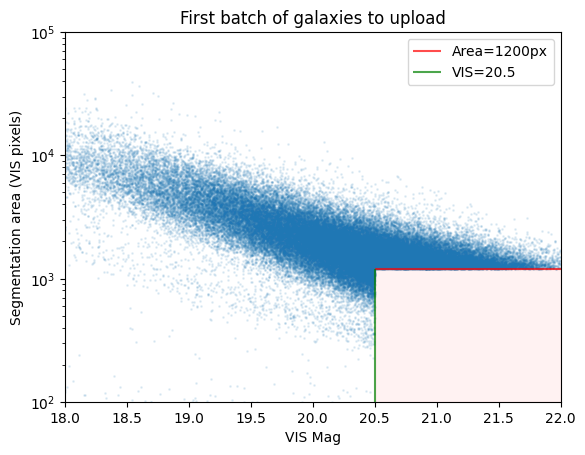

In [33]:

fig, ax = plt.subplots()
ax.scatter(master_catalog['mag_segmentation'], master_catalog['segmentation_area'], alpha=.1, s=1.)
ax.set_yscale('log')
plt.xlabel('VIS Mag')
plt.ylabel('Segmentation area (VIS pixels)')
x_min = 18
x_max = 22
y_min = 10**2
y_max = 10**5
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.hlines(1200, 20.5, x_max, linestyle='-', alpha=.7, color='r', label='Area=1200px')
ax.vlines(20.5, y_min, 1200, linestyle='-', alpha=.7, color='g', label='VIS=20.5')

alpha = .05
color = 'r'
select_x = np.linspace(x_min, x_max)

select_x = np.linspace(20.5, x_max)
ax.fill_between(select_x, y_min, 1200, color=color, alpha=alpha)
# ax.text(19.1, 400, 'Complete to VIS=20.5')
# ax.text(20.1, 5000, 'Includes faint extended galaxies')
ax.set_title('First batch of galaxies to upload')
plt.legend(loc='upper right')

In [34]:
master_catalog

,object_id,right_ascension,declination,gaia_id,segmentation_area,flux_segmentation,flux_vis_aper,ellipticity,kron_radius,flag_vis,flag_y,tile_index,mag_segmentation,vis_tile,y_tile,tile_ra,tile_dec,release_name,vis_tile_ready,y_tile_ready
0,-811486400490275240,81.148640,-49.027524,NaN,1502,14.531199,13.414946,0.176674,75.498924,2,2,102020561,20.994246,/home/walml/repos/gz-euclid-datalab/data/pipel...,/home/walml/repos/gz-euclid-datalab/data/pipel...,80.740087,-49.0,F-006,False,False
1,-811486130489671504,81.148613,-48.967150,NaN,3242,40.367764,32.305305,0.391451,130.008390,2,2,102020561,19.884913,/home/walml/repos/gz-euclid-datalab/data/pipel...,/home/walml/repos/gz-euclid-datalab/data/pipel...,80.740087,-49.0,F-006,False,False
2,-811478352490331950,81.147835,-49.033195,NaN,1743,35.794456,35.434753,0.229097,64.059770,2,2,102020561,20.015461,/home/walml/repos/gz-euclid-datalab/data/pipel...,/home/walml/repos/gz-euclid-datalab/data/pipel...,80.740087,-49.0,F-006,False,False
3,-811469634487659061,81.146963,-48.765906,NaN,1370,18.344015,16.673147,0.702853,99.839516,0,0,102020561,20.741264,/home/walml/repos/gz-euclid-datalab/data/pipel...,/home/walml/repos/gz-euclid-datalab/data/pipel...,80.740087,-49.0,F-006,False,False
4,-811469395491465316,81.146940,-49.146532,NaN,1454,41.345905,40.685246,0.201813,64.419510,0,0,102020561,19.858919,/home/walml/repos/gz-euclid-datalab/data/pipel...,/home/walml/repos/gz-euclid-datalab/data/pipel...,80.740087,-49.0,F-006,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,-685041796446627514,68.504180,-44.662751,NaN,125,28.924444,10.095722,0.778199,26.034874,0,0,102025018,20.246837,/home/walml/repos/gz-euclid-datalab/data/pipel...,/home/walml/repos/gz-euclid-datalab/data/pipel...,68.813098,-44.5,F-006,False,False
463,-684979230446998493,68.497923,-44.699849,NaN,1042,25.059847,26.009832,0.175881,58.101265,0,0,102025018,20.402554,/home/walml/repos/gz-euclid-datalab/data/pipel...,/home/walml/repos/gz-euclid-datalab/data/pipel...,68.813098,-44.5,F-006,False,False
464,-684973862446777084,68.497386,-44.677708,NaN,2293,38.636390,9.513544,0.157318,86.943390,0,0,102025018,19.932509,/home/walml/repos/gz-euclid-datalab/data/pipel...,/home/walml/repos/gz-euclid-datalab/data/pipel...,68.813098,-44.5,F-006,False,False
465,-684972864447021397,68.497286,-44.702140,NaN,1311,27.878977,28.562180,0.038642,58.532566,2,2,102025018,20.286808,/home/walml/repos/gz-euclid-datalab/data/pipel...,/home/walml/repos/gz-euclid-datalab/data/pipel...,68.813098,-44.5,F-006,False,False


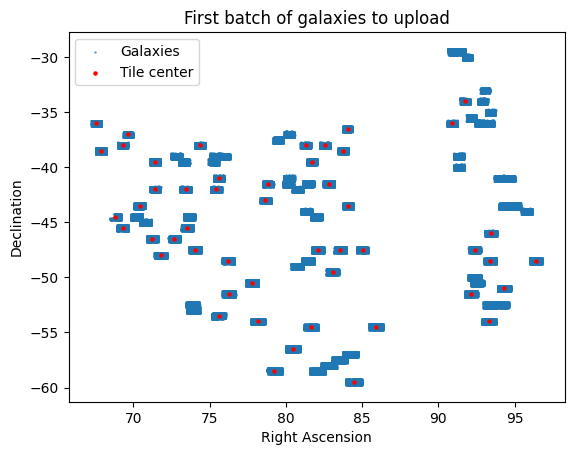

In [36]:
fig, ax = plt.subplots()

ax.scatter(master_catalog['right_ascension'], master_catalog['declination'], alpha=.5, s=1., label='Galaxies')


# ra_centers = master_catalog['tile_ra'].unique()
# dec_centers = master_catalog['tile_dec'].unique()

ax.scatter(safe_df['tile_ra'], safe_df['tile_dec'], color='r', s=5, label='Tile center')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title('First batch of galaxies to upload')
ax.legend()